In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
from scipy.spatial import cKDTree
import palm_diagnostics as pdiag

import seaborn as sns
sns.set()

```python
# %load ../grouping.py
#!/usr/bin/env python
# grouping.py
"""
All code related to drift correction of PALM data

Copyright (c) 2017, David Hoffman
"""
import psutil
import numpy as np
import pandas as pd
from scipy.spatial import cKDTree
import dask.dataframe as dd
import dask.multiprocessing
# get a logger
import logging
logger = logging.getLogger(__name__)


def find_matches(frames, radius):
    """Find matching peaks between two frames

    Parameters
    ----------
    frames : iterable of ndarrays (2, n) of len 2
        The peak locations in space
    radius : float
        the radius within which to consider peaks matched

    Returns
    -------
    pair_matches : list of lists
        A list of closest matches
    """
    frame0, frame1 = frames
    t0 = cKDTree(frame0)
    t1 = cKDTree(frame1)
    # backwards looking, find points in frame0 that match points in frame1
    pair_matches = t1.query_ball_tree(t0, radius)
    # return only the closest match.
    
    def closest_match(m, i):
        "m is index in frame1, i is index in frame0"
        if len(m) == 1:
            return [m[0], i]
        elif len(m) == 0:
            # should never get here, see list comprehension below
            raise RuntimeError("Something went wrong in `closest_match`")
        distances = ((t1.data[i] - t0.data[m])**2).sum(1)
        # return [frame0_idx, frame1_idx]
        return [m[distances.argmin()], i]
    
    # return a list with only the closest peak.
    pair_matches = [closest_match(m, i) for i, m in enumerate(pair_matches) if len(m)]
    return pair_matches


def group(df, radius, gap, frame_reset=np.inf):
    """Group peaks based on x y locations

    Parameters
    ----------
    df : pandas DataFrame
    radius : float
    gap : int
    frame_reset : int"""
    new_df_list = []
    # should add a progress bar here
    frame_min = df.frame.min()
    for frame, peaks in df.groupby("frame"):
        peaks = peaks.copy()
        # set/reset group_id
        peaks["group_id"] = -1
        if not (frame - frame_min) % frame_reset:
            # group_id will be the index of the first peak
            df_cache = peaks
            df_cache.loc[peaks.index, "group_id"] = df_cache.index
            new_df_list.append(df_cache.copy())
            continue
        # search for matches
        matches = find_matches([df_cache[["y0", "x0"]].values, peaks[["y0", "x0"]].values], radius)
        # get indices
        # need to deal with overlaps (two groups claim same peak)
        if len(matches):
            try:
                # if there is a new peak that matches to two or more different cached peaks then the newer of the
                # cached peaks claims it. If the cached peaks have the same age then its a toss up.
                cache_idx, peaks_idx = np.array([[df_cache.index[i], peaks.index[m]] for i, m in matches]).T
            except ValueError as error:
                # should log the error or raise as a warning.
                logger.warning(error)
            else:
                # update groups
                # need to use .values, because list results in DF
                peaks.loc[peaks_idx, "group_id"] = df_cache.loc[cache_idx, "group_id"].values
        # ungrouped peaks get their own group_id
        peaks.group_id.where((peaks.group_id != -1), peaks.index, inplace=True)
        # peaks.loc[(peaks.group_id != -1), "group_id"] = peaks.index
        # update df_cache and lifetimes
        # updating the cache takes a significant amount of time.
        df_cache = pd.concat((df_cache, peaks))
        df_cache = df_cache.drop_duplicates("group_id", "last")
        df_cache = df_cache[(frame - df_cache.frame) < gap]
        new_df_list.append(peaks)
    return pd.concat(new_df_list)

def agg_groups(df_grouped):
    # define coordinates
    coords = ["x", "y", "z"]
    # save the labels for weighted coords and weights
    w_coords = []
    weights = []
    # loop through coords generating weights and weighted coords
    for c in coords:
        s = "sigma_" + c
        df_grouped[s + "_inv"] = 1 / df_grouped[s] ** 2
        weights.append(s + "_inv")
        x = c + "0"
        df_grouped[x + "_w"] = df_grouped[x].mul(df_grouped[s + "_inv"], "index")
        w_coords.append(x + "_w")
    # groupby group_id and sum
    temp_gb = df_grouped.groupby("group_id")
    # finish weighted mean
    new_coords = temp_gb[w_coords].sum() / temp_gb[weights].sum().values
    new_coords.columns = [c.replace("_w", "") for c in new_coords.columns]
    # calc new sigma
    new_sigmas = np.sqrt(1 / temp_gb[weights].sum())
    new_sigmas.columns = [c.replace("_inv", "") for c in new_sigmas.columns]
    # calc new group params
    new_amp = temp_gb[["amp", "nphotons", "chi2"]].sum()
    new_frame = temp_gb[["frame"]].last()
    groupsize = temp_gb.x0.count()
    groupsize.name = "groupsize"
    new_offset = temp_gb[["offset"]].mean()
    # drop added columns from original data frame
    df_grouped.drop(columns=w_coords + weights, inplace=True)
    # return new data frame
    return pd.concat([new_coords, new_sigmas, new_amp, new_frame, groupsize, new_offset], axis=1)

```

In [2]:
def find_matches(frames, radius):
    """Find matching peaks between two frames

    Parameters
    ----------
    frames : iterable of ndarrays (2, n) of len 2
        The peak locations in space
    radius : float
        the radius within which to consider peaks matched

    Returns
    -------
    pair_matches : list of lists
        A list of closest matches
    """
    frame0, frame1 = frames
    t0 = cKDTree(frame0)
    t1 = cKDTree(frame1)
    # backwards looking, find points in frame0 that match points in frame1
    pair_matches = t1.query_ball_tree(t0, radius)
    # return only the closest match.
    
    def closest_match(m, i):
        "m is index in frame1, i is index in frame0"
        if len(m) == 1:
            return [m[0], i]
        elif len(m) == 0:
            # should never get here, see list comprehension below
            raise RuntimeError("Something went wrong in `closest_match`")
        distances = ((t1.data[i] - t0.data[m])**2).sum(1)
        # return [frame0_idx, frame1_idx]
        return [m[distances.argmin()], i]
    
    # return a list with only the closest peak.
    pair_matches = [closest_match(m, i) for i, m in enumerate(pair_matches) if len(m)]
    return pair_matches

def agg_groups_old(df_grouped):
    # define coordinates
    coords = ["x", "y", "z"]
    # save the labels for weighted coords and weights
    w_coords = []
    weights = []
    # loop through coords generating weights and weighted coords
    for c in coords:
        s = "sigma_" + c
        df_grouped[s + "_inv"] = 1 / df_grouped[s] ** 2
        weights.append(s + "_inv")
        x = c + "0"
        df_grouped[x + "_w"] = df_grouped[x].mul(df_grouped[s + "_inv"], "index")
        w_coords.append(x + "_w")
    # groupby group_id and sum
    temp_gb = df_grouped.groupby("group_id")
    # finish weighted mean
    new_coords = temp_gb[w_coords].sum() / temp_gb[weights].sum().values
    new_coords.columns = [c.replace("_w", "") for c in new_coords.columns]
    # calc new sigma
    new_sigmas = np.sqrt(1 / temp_gb[weights].sum())
    new_sigmas.columns = [c.replace("_inv", "") for c in new_sigmas.columns]
    # calc new group params
    new_amp = temp_gb[["amp", "nphotons", "chi2"]].sum()
    new_frame = temp_gb[["frame"]].last()
    groupsize = temp_gb.x0.count()
    groupsize.name = "groupsize"
    new_offset = temp_gb[["offset"]].mean()
    # drop added columns from original data frame
    df_grouped.drop(columns=w_coords + weights, inplace=True)
    # return new data frame
    return pd.concat([new_coords, new_sigmas, new_amp, new_frame, groupsize, new_offset], axis=1)

def group(df, radius, gap, frame_reset=np.inf):
    """Group peaks based on x y locations

    Parameters
    ----------
    df : pandas DataFrame
    radius : float
    gap : int
    frame_reset : int"""
    new_df_list = []
    # should add a progress bar here
    frame_min = df.frame.min()
    for frame, peaks in df.groupby("frame"):
        peaks = peaks.copy()
        # set/reset group_id
        peaks["group_id"] = -1
        if not (frame - frame_min) % frame_reset:
            # group_id will be the index of the first peak
            df_cache = peaks
            df_cache.loc[peaks.index, "group_id"] = df_cache.index
            new_df_list.append(df_cache.copy())
            continue
        # search for matches
        matches = find_matches([df_cache[["y0", "x0"]].values, peaks[["y0", "x0"]].values], radius)
        # get indices
        # need to deal with overlaps (two groups claim same peak)
        if len(matches):
            try:
                # if there is a new peak that matches to two or more different cached peaks then the newer of the
                # cached peaks claims it. If the cached peaks have the same age then its a toss up.
                cache_idx, peaks_idx = np.array([[df_cache.index[i], peaks.index[m]] for i, m in matches]).T
            except ValueError as error:
                # should log the error or raise as a warning.
                logger.warning(error)
            else:
                # update groups
                # need to use .values, because list results in DF
                peaks.loc[peaks_idx, "group_id"] = df_cache.loc[cache_idx, "group_id"].values
        # ungrouped peaks get their own group_id
        peaks.group_id.where((peaks.group_id != -1), peaks.index, inplace=True)
        # peaks.loc[(peaks.group_id != -1), "group_id"] = peaks.index
        # update df_cache and lifetimes
        # updating the cache takes a significant amount of time.
        df_cache = pd.concat((df_cache, peaks))
        df_cache = agg_groups(df_cache).reset_index()
#         df_cache = df_cache.drop_duplicates("group_id", "last")
#         df_cache = df_cache.groupby("group_id").mean().reset_index()
        df_cache = df_cache[(frame - df_cache.frame) < gap]
#         print(df_cache)
        new_df_list.append(peaks)
    return pd.concat(new_df_list)


def agg_groups(df_grouped):
    """Aggregate groups
    
    https://en.wikipedia.org/wiki/Weighted_arithmetic_mean#Weighted_sample_variance
    """
    # find groups
    groups = df_grouped.duplicated("group_id", False)
    solitary = df_grouped[~groups].set_index("group_id")
    # need copy otherwise we may change original set
    to_group = df_grouped[groups].copy()
    # define coordinates
    coords = ["x", "y", "z"]
    # save the labels for weighted coords and weights
    w_coords = []
    w_coords2 = []
    weights = []
    # loop through coords generating weights and weighted coords
    for c in coords:
        # calculate weights
        s = "sigma_" + c
        to_group[s + "_inv"] = 1 / to_group[s] ** 2
        weights.append(s + "_inv")
        x = c + "0"
        # weighted position
        to_group[x + "_w"] = to_group[x].mul(to_group[s + "_inv"], "index")
        w_coords.append(x + "_w")
        # weighted position^2
        to_group[x + "_w2"] = (to_group[x]**2).mul(to_group[s + "_inv"], "index")
        w_coords2.append(x + "_w2")
    # groupby group_id and sum
    temp_gb = to_group.groupby("group_id")
    # calculate sum weights
    sum_w = temp_gb[weights].sum().values
    # finish weighted mean
    new_coords = temp_gb[w_coords].sum() / sum_w
    # doing this here to preserve order
    new_coords2_values = (new_coords**2)[w_coords].values
    new_coords.columns = [c.replace("_w", "") for c in new_coords.columns]
    # calc new sigma
    # \sqrt{\frac{\sum w_i x_i^2}{\sum w_i} - \mu^{*2} + \sigma^{*2}}
    new_sigmas = np.sqrt((temp_gb[w_coords2].sum() + 1) / sum_w -
                         new_coords2_values)
    new_sigmas.columns = ["sigma_" + c[0] for c in new_sigmas.columns]
    # calc new group params
    new_amp = temp_gb[["amp", "nphotons", "chi2"]].sum()
    new_frame = temp_gb[["frame"]].last()
    groupsize = temp_gb.x0.count()
    groupsize.name = "groupsize"
    new_offset = temp_gb[["offset"]].mean()
    # return new data frame
    grouped = pd.concat([new_coords, new_sigmas, new_amp, new_frame, groupsize, new_offset], axis=1)
    solitary = solitary.assign(groupsize=1)
    return pd.concat((solitary, grouped)).sort_index()

def agg_groups2(df_grouped):
    # define coordinates
    coords = ["x", "y", "z"]
    # save the labels for weighted coords and weights
    w_coords = []
    w_coords2 = []
    weights = []
    # loop through coords generating weights and weighted coords
    for c in coords:
        # calculate weights
        s = "sigma_" + c
        df_grouped[s + "_inv"] = 1 / df_grouped[s] ** 2
        weights.append(s + "_inv")
        x = c + "0"
        # weighted position
        df_grouped[x + "_w"] = df_grouped[x].mul(df_grouped[s + "_inv"], "index")
        w_coords.append(x + "_w")
        # weighted position^2
        df_grouped[x + "_w2"] = (df_grouped[x]**2).mul(df_grouped[s + "_inv"], "index")
        w_coords2.append(x + "_w2")
    # groupby group_id and sum
    temp_gb = df_grouped.groupby("group_id")
    # calculate sum weights
    sum_w = temp_gb[weights].sum().values
    # finish weighted mean
    new_coords = temp_gb[w_coords].sum() / sum_w
    # doing this here to preserve order
    new_coords2_values = (new_coords**2)[w_coords].values
    new_coords.columns = [c.replace("_w", "") for c in new_coords.columns]
    # calc new sigma
    # basically the weighted std dev of the points added in quadrature to the 
    # std dev of the std dev of all points
    # $$
    # \sqrt{\frac{\sum w_i (x_i - \mu^*)^2}{\sum w_i} + \frac{1}{\sum w_i}} \\
    # \sqrt{\frac{\sum w_i x_i^2}{\sum w_i} - \mu^{*2} + \frac{1}{\sum w_i}} \\
    # \sqrt{\frac{\sum w_i x_i^2 + 1}{\sum w_i} - \mu^{*2}} \\
    # w_i = \frac{1}{\sigma_i^2}
    # $$
    new_sigmas = np.sqrt((temp_gb[w_coords2].sum() + 1) / sum_w -
                         new_coords2_values)
    new_sigmas.columns = ["sigma_" + c[0] for c in new_sigmas.columns]
    # calc new group params
    new_amp = temp_gb[["amp", "nphotons", "chi2"]].sum()
    new_frame = temp_gb[["frame"]].last()
    groupsize = temp_gb.x0.count()
    groupsize.name = "groupsize"
    new_offset = temp_gb[["offset"]].mean()
    # drop added columns from original data frame
    df_grouped.drop(columns=w_coords + weights + w_coords2, inplace=True)
    # return new data frame
    return pd.concat([new_coords, new_sigmas, new_amp, new_frame, groupsize, new_offset], axis=1)

$$
\sqrt{\frac{\sum w_i (x_i - \mu^*)^2}{\sum w_i} + \frac{1}{\sum w_i}} \\
\sqrt{\frac{\sum w_i x_i^2}{\sum w_i} - \mu^{*2} + \frac{1}{\sum w_i}} \\
\sqrt{\frac{\sum w_i x_i^2 + 1}{\sum w_i} - \mu^{*2}} \\
w_i = \frac{1}{\sigma_i^2}
$$

In [3]:
grouped = pd.read_hdf("TestGrpData.h5", "grouped")
processed = pd.read_hdf("TestGrpData.h5", "processed")

In [4]:
grp = (group(processed, 0.2, 30))
%timeit agg_groups(grp)
%timeit agg_groups_old(grp)

15.5 ms ± 73.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
10.8 ms ± 355 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [5]:
%time processed_grp = pdiag.agg_groups(pdiag.group(processed, 0.2, 30))

CPU times: user 19.5 s, sys: 84.5 ms, total: 19.6 s
Wall time: 19.6 s


<class 'pandas.core.frame.DataFrame'>
Int64Index: 958 entries, 289222 to 233929752
Data columns (total 12 columns):
frame        958 non-null int32
x0           958 non-null float64
y0           958 non-null float64
sigma_x      958 non-null float64
sigma_y      958 non-null float64
sigma_z      958 non-null float64
nphotons     958 non-null float64
groupsize    958 non-null int32
z0           958 non-null float64
offset       958 non-null float64
amp          958 non-null float64
chi2         958 non-null float64
dtypes: float64(10), int32(2)
memory usage: 89.8 KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 985 entries, 289222 to 233929924
Data columns (total 12 columns):
x0           985 non-null float64
y0           985 non-null float64
z0           985 non-null float64
sigma_x      985 non-null float64
sigma_y      985 non-null float64
sigma_z      985 non-null float64
amp          985 non-null float64
nphotons     985 non-null float64
chi2         985 non-null float64
frame 

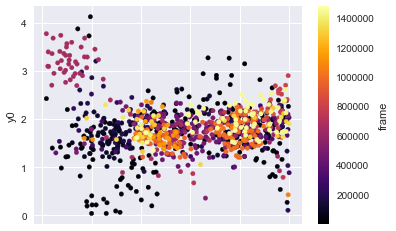

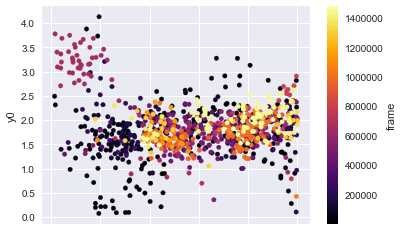

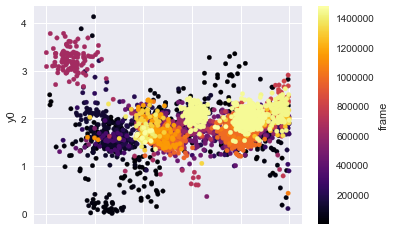

In [6]:
for v in grouped, processed_grp, processed:
    v.plot("x0", "y0", c="frame", cmap="inferno", kind="scatter")
    v.info()

/Users/david/Box Sync/Python/dphutils/__init__.py:119: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  if np.issubdtype(data.dtype, np.complex):
/Users/david/anaconda3/lib/python3.6/site-packages/dask/local.py:271: RuntimeWarning: invalid value encountered in true_divide
  return func(*args2)
/Users/david/Box Sync/Python/dphutils/__init__.py:119: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  if np.issubdtype(data.dtype, np.complex):
/Users/david/anaconda3/lib/python3.6/site-packages/dask/local.py:271: RuntimeWarning: invalid value encountered in true_divide
  return func(*args2)
/Users/david/Box Sync/Python/dphutils/__init__.py:119: FutureWarning: Conversion of the second argument of issubdtype 

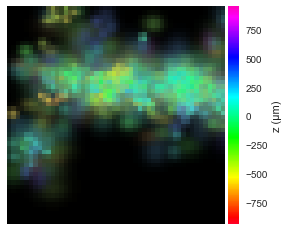

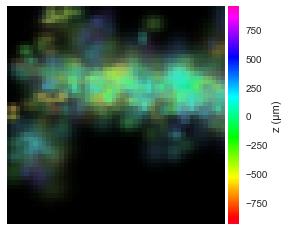

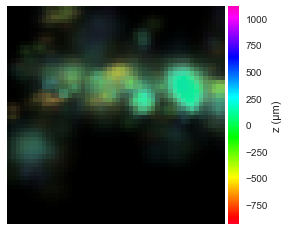

In [7]:
for v in grouped, processed_grp, processed:
    cimg = pdiag.gen_img((5,5), v, hist=False, diffraction_limit=True)
    cimg.plot(norm_kwargs=dict(gamma=0.5, vmax=0.1))

In [8]:
import matplotlib.pyplot as plt

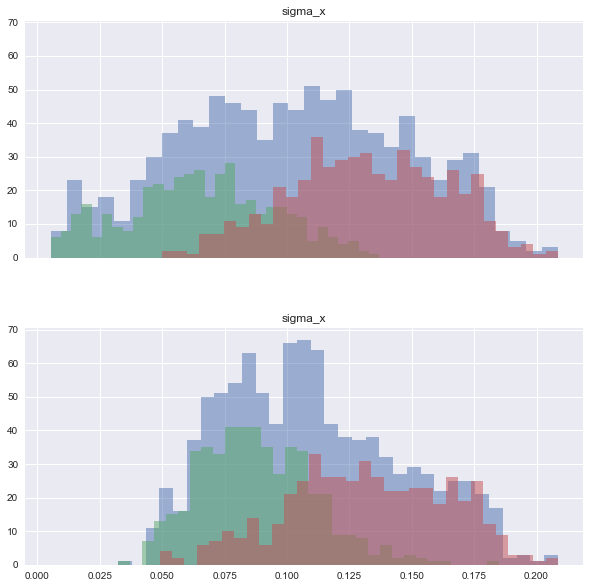

In [9]:
fig, axs = plt.subplots(2, sharex=True, sharey=True, figsize=(10,10))
c = ["sigma_x"]
for ax, v in zip(axs, (grouped, processed_grp)):
    v[c].hist(bins=32, ax=ax, alpha=0.5)
    v[v.groupsize > 1][c].hist(bins=32, ax=ax, alpha=0.5)
    v[v.groupsize == 1][c].hist(bins=32, ax=ax, alpha=0.5)

In [10]:
counts = np.fmax(np.random.poisson(2, size=1000000), 1)
group_id = []
for i, c in enumerate(counts):
    group_id.extend([i] * c)

In [11]:
len(group_id)

2137555

In [12]:
junk = pd.DataFrame(data=np.random.rand(len(group_id), len(processed.columns)), columns=processed.columns)
junk["group_id"] = group_id
junk.head()

,x0,y0,nphotons,frame,sigma_x,sigma_y,sigma_z,z0,offset,amp,chi2,group_id
0,0.079577,0.190022,0.544810,0.820506,0.664915,0.328940,0.879817,0.387699,0.885962,0.450722,0.583034,0
1,0.754590,0.173963,0.597327,0.162046,0.634541,0.095689,0.415208,0.094280,0.036601,0.050628,0.492137,0
2,0.300391,0.796011,0.102104,0.907450,0.842738,0.771021,0.071451,0.291181,0.286920,0.962668,0.165663,0
3,0.567361,0.349490,0.246236,0.996344,0.908510,0.796588,0.434813,0.161138,0.700865,0.353786,0.818054,1
4,0.160690,0.333809,0.621066,0.509698,0.708712,0.745898,0.459168,0.028435,0.344022,0.377326,0.377002,1


In [13]:
d = junk.duplicated("group_id", False)
# number duplicated
d.sum() / (~d).sum()

4.271106694318202

In [14]:
d.sum()

1732032

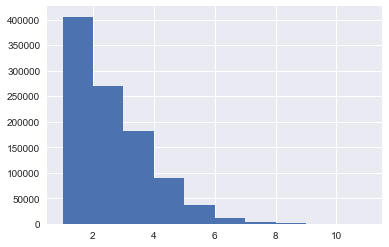

In [15]:
junk.groupby("group_id").x0.count().hist(bins=np.arange(1,12))

In [16]:
%timeit agg_groups(junk)
%timeit agg_groups2(junk)
%timeit agg_groups_old(junk)

2.09 s ± 57.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.4 s ± 47 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.17 s ± 3.71 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [17]:
a1 = agg_groups(junk)

In [18]:
a2 = agg_groups2(junk)

In [19]:
np.allclose(a1[a1.columns], a2[a1.columns])

True

In [20]:
junk.head()

,x0,y0,nphotons,frame,sigma_x,sigma_y,sigma_z,z0,offset,amp,chi2,group_id
0,0.079577,0.190022,0.544810,0.820506,0.664915,0.328940,0.879817,0.387699,0.885962,0.450722,0.583034,0
1,0.754590,0.173963,0.597327,0.162046,0.634541,0.095689,0.415208,0.094280,0.036601,0.050628,0.492137,0
2,0.300391,0.796011,0.102104,0.907450,0.842738,0.771021,0.071451,0.291181,0.286920,0.962668,0.165663,0
3,0.567361,0.349490,0.246236,0.996344,0.908510,0.796588,0.434813,0.161138,0.700865,0.353786,0.818054,1
4,0.160690,0.333809,0.621066,0.509698,0.708712,0.745898,0.459168,0.028435,0.344022,0.377326,0.377002,1
